## import modules

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:

import time
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn.functional as F

In [142]:

from torch.utils.data import DataLoader, TensorDataset
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext


## load extracted features 

In [7]:

path_to_train_dataset = "outputs/train_dataset20180327-092337"
#path_to_train_dataset_info = "outputs/train_dataset_info20180326-014122"
path_to_valid_dataset = "outputs/valid_dataset20180327-144622"
#path_to_valid_dataset_info = "outputs/valid_dataset_info20180326-014124"
path_to_test_dataset = "outputs/test_dataset20180327-153245"
#path_to_test_dataset_info = "outputs/test_dataset_info20180325-230951"

In [8]:
spark = SparkSession.builder.appName('X14').getOrCreate()

train = spark.sparkContext.textFile(path_to_train_dataset)

train_splits = train.randomSplit([1] * 12, 2018)

In [9]:
train_data = np.array(train_splits[0].map(lambda x: np.array(x.split(","),dtype=np.float32)).collect())
for i in range(1,len(train_splits)):
    train_data = np.row_stack((train_data,np.array(train_splits[i].map(lambda x: np.array(x.split(","),dtype=np.float32)).collect())))

In [10]:
valid = spark.sparkContext.textFile(path_to_valid_dataset)

valid_splits = valid.randomSplit([1] * 12, 2018)
valid_data = np.array(valid_splits[0].map(lambda x: np.array(x.split(","),dtype=np.float32)).collect())
for i in range(1,len(valid_splits)):
    valid_data = np.row_stack((valid_data,np.array(valid_splits[i].map(lambda x: np.array(x.split(","),dtype=np.float32)).collect())))

In [11]:
test = spark.sparkContext.textFile(path_to_test_dataset)

test_splits = test.randomSplit([1] * 12, 2018)
test_data = np.array(test_splits[0].map(lambda x: np.array(x.split(","),dtype=np.float32)).collect())
for i in range(1,len(test_splits)):
    test_data = np.row_stack((test_data,np.array(test_splits[i].map(lambda x: np.array(x.split(","),dtype=np.float32)).collect())))

In [12]:
train_data.shape,valid_data.shape,test_data.shape

((78383, 2064), (11318, 2064), (22403, 2064))

In [13]:
X_train, y_train = train_data[:,:-14],train_data[:,-14:]
X_val, y_val = valid_data[:,:-14],valid_data[:,-14:]
X_test, y_test = test_data[:,:-14],test_data[:,-14:]

## calculate weights for loss function

In [24]:
classes_positive_counts = y_train.sum(axis=0)

classes_positive_counts

array([  171.,   994.,  1211.,  1620.,  1769.,  1969.,  2378.,  3267.,
        3756.,  4066.,  4504.,  8098.,  9349., 13912.], dtype=float32)

In [25]:
weights_neg = classes_positive_counts/y_train.shape[0]
weights_neg

array([0.0021816 , 0.01268132, 0.01544978, 0.02066775, 0.02256867,
       0.02512024, 0.03033821, 0.04167996, 0.04791855, 0.05187349,
       0.05746144, 0.10331322, 0.11927331, 0.17748747])

In [26]:
weights_pos = 1 - weights_neg
weights_pos

array([0.9978184 , 0.98731868, 0.98455022, 0.97933225, 0.97743133,
       0.97487976, 0.96966179, 0.95832004, 0.95208145, 0.94812651,
       0.94253856, 0.89668678, 0.88072669, 0.82251253])

In [27]:
pw = torch.autograd.Variable(torch.FloatTensor(weights_pos)).cuda()
nw = torch.autograd.Variable(torch.FloatTensor(weights_neg)).cuda()

In [28]:
weights = (nw,pw)

In [29]:
def weighted_bceLoss(output,target,weights):
    loss = weights[1] * target * torch.log(output) + weights[0] * (1-target) * torch.log(1-output)
    return torch.neg(torch.mean(loss))

## method to calculate auroc and thresholds

In [14]:

def compute_auroc(true_labels, predicts, class_count):
        
        auroc = []
        optimal_thresholds = []
        np_tl = true_labels.cpu().numpy()
        np_pred = predicts.cpu().numpy()
        
        for i in range(class_count):
            auroc.append(roc_auc_score(np_tl[:, i], np_pred[:, i]))
            fpr, tpr, thresholds = roc_curve(np_tl[:, i], np_pred[:, i])
            optimal_idx = np.argmax(tpr - fpr)
            optimal_thresholds.append(thresholds[optimal_idx])
        return auroc,optimal_thresholds

## define the model

In [15]:


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=2050, out_features=128, bias=True)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=14, bias=True)

    def forward(self, x):
        x = x.view(-1, 2050)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x


## prepare tensor loaders

In [16]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(1), torch.from_numpy(y_train.astype('float32')))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

valset = TensorDataset(torch.from_numpy(X_val.astype('float32')).unsqueeze(1), torch.from_numpy(y_val.astype('float32')))
valloader = torch.utils.data.DataLoader(valset, batch_size=10, shuffle=False, num_workers=2)

testset = TensorDataset(torch.from_numpy(X_test.astype('float32')).unsqueeze(1), torch.from_numpy(y_test.astype('float32')))
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)



## define method to evaluate training set

In [17]:
def evaluate_train(m):
    
    m.eval()
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()
    for data in trainloader:
        
        inputs, targets = data    

        target = targets.cuda()
        gt = torch.cat((gt, target), 0)
        out = m(Variable(inputs).cuda())
        
        pred = torch.cat((pred, out.data), 0)
    auroc,optimal_thresholds = compute_auroc(gt,pred,14)
    return auroc,optimal_thresholds

In [143]:
def evaluate_test(m):
    
    m.eval()
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()
    for data in testloader:
        
        inputs, targets = data    

        target = targets.cuda()
        gt = torch.cat((gt, target), 0)
        out = m(Variable(inputs).cuda())
        
        pred = torch.cat((pred, out.data), 0)
    auroc,optimal_thresholds = compute_auroc(gt,pred,14)
    return auroc,optimal_thresholds

In [151]:
def train(weights,lr=0.001,weight_decay=1e-5,epochs = 50, scheduler_factor = 0.2, patience = 1):
    cuda = torch.cuda.is_available()
    model = ConvNet()
    criterion = nn.BCELoss()
    criterion.forward = weighted_bceLoss
    optimizer = optim.Adam (model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, factor = scheduler_factor, patience = patience, mode = 'min')
    if cuda:
        model = model.cuda()
    auroc_initial,_ = evaluate_test(model)
    train_losses = []
    valid_losses = []
    best_model = None
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    min_loss = 1000
    
    
    start_time = time.time()
    
    for epoch in range(epochs):  

        model.train()
        train_loss = 0.0
        train_counter = 0
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data

            inputs, targets = Variable(inputs), Variable(targets)
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda(async = True)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets,weights)
            loss.backward()
            optimizer.step()

            train_loss += (loss.data[0] * inputs.size(0))
            train_counter += inputs.size(0)

        train_losses.append(train_loss/train_counter)

        model.eval()
        valid_loss = 0.0
        valid_counter = 0
        losstensorMean = 0
        for i, data in enumerate(valloader, 0):

            inputs, targets = data

            inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda(async = True)

            outputs = model(inputs)

            loss = criterion(outputs, targets,weights)
            losstensorMean += loss
            valid_loss += (loss.data[0] * inputs.size(0))
            valid_counter += inputs.size(0)
        m_val_loss = valid_loss/valid_counter
        m_val_loss_tensor = losstensorMean/valid_counter
        valid_losses.append(m_val_loss)

        if m_val_loss < min_loss:
            min_loss = m_val_loss
            best_model = model
            torch.save(model.state_dict(),'model' + timestamp + '.pth.tar')
            print ('Epoch [' + str(epoch + 1) + '] [' + time.strftime("%Y%m%d-%H%M%S") + '] loss= ' + str(m_val_loss))
        scheduler.step(m_val_loss_tensor.data[0])
    print('Finished Training ')
    print(time.time()-start_time)
    auroc,optimal_thresholds = evaluate_train(best_model)
    return auroc_initial,best_model,auroc,optimal_thresholds, train_losses, valid_losses,min_loss,timestamp

In [51]:
def tune_lr_weight_decay():
    log_cols=["lr","weight_decay", "min_loss","timestamp"]
    performance_df = pd.DataFrame(columns = log_cols)
    lrs = [0.003,0.001,0.0003,0.0001,0.00003]
    weight_decays = [1e-4,1e-5,1e-6,0]
    auroc_initial_best = None
    timestamp_best = None
    best_model_best = None
    train_losses_best = None
    valid_losses_best = None
    min_loss_best = 1000000;
    for lr in lrs:
        for weight_decay in weight_decays:
            auroc_initial,best_model,auroc,optimal_thresholds, train_losses, valid_losses,min_loss,timestamp = train(weights,lr=lr,weight_decay=weight_decay)
            log_entry = pd.DataFrame([[lr, weight_decay, min_loss,timestamp]], columns=log_cols)
            performance_df = performance_df.append(log_entry)
            if min_loss_best > min_loss:
                auroc_initial_best = auroc_initial
                timestamp_best = timestamp
                best_model_best = best_model
                train_losses_best = train_losses
                valid_losses_best = valid_losses
                min_loss_best = min_loss
    return auroc_initial_best, timestamp_best, best_model_best, train_losses_best, valid_losses_best,min_loss_best,  performance_df
    

In [53]:
auroc_initial_best, timestamp_best, best_model_best, train_losses_best, valid_losses_best,min_loss_best,  performance_df = tune_lr_weight_decay()

Epoch [1] [20180421-195835] loss= 0.06470189275679855
Epoch [2] [20180421-195902] loss= 0.06469731579035558
Epoch [4] [20180421-195952] loss= 0.059801447077700874
Epoch [5] [20180421-200018] loss= 0.059184576656763514
Epoch [8] [20180421-200134] loss= 0.058738297031559396
Epoch [9] [20180421-200201] loss= 0.05855999734890579
Epoch [10] [20180421-200227] loss= 0.0580404636648094
Epoch [11] [20180421-200252] loss= 0.05763603593228557
Epoch [12] [20180421-200318] loss= 0.05762460337085134
Epoch [13] [20180421-200343] loss= 0.05743770729990672
Epoch [14] [20180421-200409] loss= 0.0570540984595179
Epoch [16] [20180421-200500] loss= 0.05686917538088283
Epoch [19] [20180421-200622] loss= 0.05671829862902239
Epoch [22] [20180421-200753] loss= 0.056642370246993264
Epoch [24] [20180421-200848] loss= 0.056638573497970905
Epoch [25] [20180421-200915] loss= 0.056618240351533115
Finished Training 
1308.1027908325195
Epoch [1] [20180421-202052] loss= 0.0647213897096919
Epoch [2] [20180421-202120] los

In [54]:
performance_df

,lr,weight_decay,min_loss,timestamp
0,0.00300,0.000100,0.056618,20180421-195810
0,0.00300,0.000010,0.054853,20180421-202024
0,0.00300,0.000001,0.055640,20180421-204402
0,0.00300,0.000000,0.064674,20180421-210824
0,0.00100,0.000100,0.057061,20180421-213127
0,0.00100,0.000010,0.055025,20180421-215424
0,0.00100,0.000001,0.055199,20180421-221627
0,0.00100,0.000000,0.055738,20180421-223825
0,0.00030,0.000100,0.055254,20180421-225942
0,0.00030,0.000010,0.054525,20180421-232120


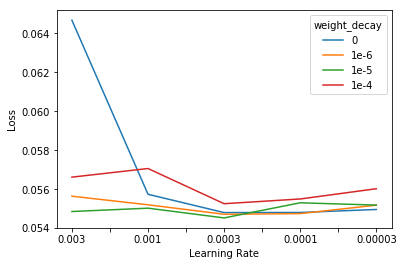

In [93]:
ax = plt.subplot(1,1,1)
plt.plot(np.arange(5), performance_df[performance_df['weight_decay'] == 0].min_loss.values, label='0')
plt.plot(np.arange(5), performance_df[performance_df['weight_decay'] == 0.000001].min_loss.values, label='1e-6')
plt.plot(np.arange(5), performance_df[performance_df['weight_decay'] == 0.00001].min_loss.values, label='1e-5')
plt.plot(np.arange(5), performance_df[performance_df['weight_decay'] == 0.0001].min_loss.values, label='1e-4')

plt.ylabel('Loss')
plt.xlabel('Learning Rate')
ax.set_xticklabels(['','0.003','','0.001','','0.0003','','0.0001','','0.00003'])
plt.legend(loc="best",title='weight_decay')

In [55]:
timestamp_best

'20180421-232120'

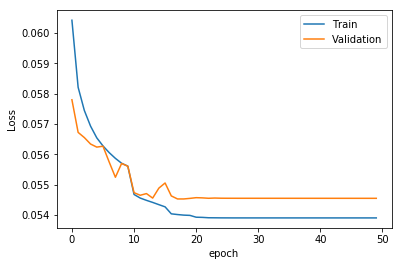

In [141]:
plt.figure()
plt.plot(np.arange(len(train_losses_best)), train_losses_best, label='Train')
plt.plot(np.arange(len(valid_losses_best)), valid_losses_best, label='Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc="best")

In [148]:
test_auroc,_ = evaluate_test(best_model)

In [149]:
df = pd.DataFrame({'trained':test_auroc, 'initial':auroc_initial_best, 'disease':('Hernia', 'Pneumonia', 
               'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly',  
               'Pleural_Thickening',  'Consolidation',  'Pneumothorax',  
               'Mass',  'Nodule',  'Atelectasis', 'Effusion', 'Infiltration'),'Wang, 2017':(0.767,0.633,0.769,0.835,0.815,0.807,0.708,0.708,0.806,0.706,0.671,0.716,0.784,0.609),'Rajpurkar, 2017':(0.9164,0.7680,0.8047,0.8878,0.9371,0.9248,0.8062,0.7901,0.8887,0.8676,0.7802,0.8094,0.8638,0.7345)})

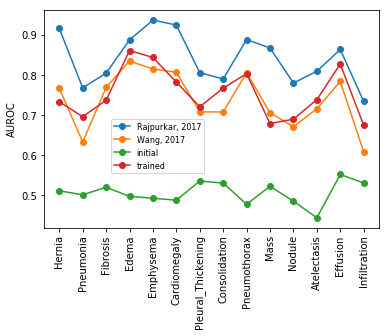

In [150]:
ax = df.set_index('disease').plot(style="o-")
ax.set_ylabel("AUROC")
ax.set_xlabel("")
ax.set_xticks(np.arange(14))
ax.set_xticklabels(df['disease'].tolist(),rotation=90)
ax.legend(loc=[0.2,0.25],prop={'size':8},fancybox=True)
